<center>
<img src="FIFA-19-Background-1-768x401.jpg" />
    
## Aprendizaje No Supervisado 2020 DiploDatos
    Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni
## Agrupamiento con el FIFA 2019 dataset
    
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Clustering KM](#3.-Clustering-con-Kmeans)
4. [Clustering MS](#4.-Clustering-con-Mean-Shift)
5. [Clustering KM2](#5.-Clustering-con-Kmeans-sin-arqueros)
6. [Clustering MS2](#6.-Clustering-con-Mean-Shift-sin-arqueros)

## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

Para visualización usamos plotly, pero podemos usar seaborn tambien, o matplotlib. 

In [2]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [3]:
df=pd.read_csv("datasets/players_20.csv")

**Preparamos la base para Clustering:**

**Retiramos jugadores con bajo Desempeño global ("Overall")**

**y consideramos Variables de desempeño por habilidad (skills_ratings)**

In [4]:
n=10000

df_n=df.loc[:n] #los primeros n
df_n=df_n[(df_n['overall']>70)] # mejores jugadores

skills_ratings=['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving',
                'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning',
                'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
                'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve',
                'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
                'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
                'movement_reactions', 'movement_balance', 'power_shot_power',
                'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
                'mentality_aggression', 'mentality_interceptions', 'mentality_positioning',
                'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking',
                'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 
                'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

print(len(skills_ratings))

df_n = df_n.fillna(value=0)

df_skills=df_n[skills_ratings]


46


In [5]:
df_n[ ['short_name'] + skills_ratings ]

,short_name,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,87.0,92.0,92.0,96.0,39.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,90.0,93.0,82.0,89.0,35.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,91.0,85.0,87.0,95.0,32.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,0.0,0.0,0.0,0.0,0.0,0.0,87.0,92.0,78.0,89.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,91.0,83.0,86.0,94.0,35.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4751,Marlion Rolim,67.0,66.0,65.0,69.0,49.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,58,70,54,68,59,64,62,41,65,73,62,71,72,75,78,58,44,52,54,68,60,65,74,71,55,76,34,52,46,12,12,16,7,8
4752,Túlio Sandoiro,64.0,71.0,62.0,73.0,33.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,57,71,66,64,75,74,67,68,58,75,66,62,67,73,57,73,64,65,79,70,60,37,65,66,70,71,18,33,36,8,8,10,12,12
4753,D. Guzman,58.0,60.0,70.0,68.0,68.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,70,53,61,70,51,69,70,53,77,68,60,57,67,69,64,71,63,77,68,64,83,65,65,68,61,69,69,71,65,10,7,12,13,8
4754,R. Procházka,64.0,59.0,62.0,67.0,72.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,58,54,68,66,50,67,49,53,64,69,62,66,64,70,65,70,61,73,77,64,71,72,56,65,61,69,71,73,72,6,10,9,11,7


# 3.-Clustering-con-Kmeans

ES necesario definirle la cantidad de grupos/clusters (n_clusters), es un hiperparámetro del algoritmo. 


In [6]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster / Inertia: ', km.inertia_)

Suma de los cuadrados de las distancias al cluster / Inertia:  13785341.903633654


**Elección de la cantidad de grupos/clusters**

Una forma de seleccionar la cantidad más adecuada de clusters es probar varias cantidades y usar el criterio del codo: "elbow method", utilizando una medida de ajuste que puede ser Inertia.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

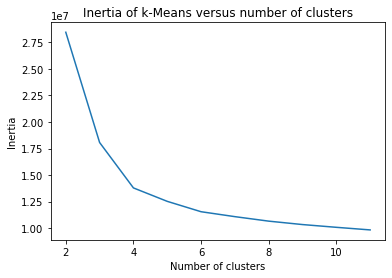

In [7]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i+2).fit(df_skills).inertia_ for i in range(10)]

from matplotlib import pyplot as plt
plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

**Graficamos el resultado kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez**

In [8]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[34]
skill_2=skills_ratings[38]


kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Ckacks!!',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [9]:
df_clusters=df_n.copy()
df_clusters['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros forzamos la cantidad')

Kmeans encontró:  4 clusters, nosotros forzamos la cantidad


**EVALUACIÓN**

**EJERCICIO: Análisis exploratorio de los clusters, usando las clases asignadas por kmeans** 
- Cantidad de observaciones por Cluster
- Análisis descriptivo separando por Cluster
- Tabla de contingencia alguna categórica vs clusters
- Silohuette?


In [10]:
# Cantidad de observaciones por Cluster

y = km.predict(df_skills)
classes = set(y)
cant_classes = [0, 0, 0, 0]

for element in y:
    if element in classes:
        cant_classes[element] += 1

In [11]:
print('Cantidad cluster 0: {}'.format(cant_classes[0]))
print('Cantidad cluster 1: {}'.format(cant_classes[1]))
print('Cantidad cluster 2: {}'.format(cant_classes[2]))
print('Cantidad cluster 3: {}'.format(cant_classes[3]))

Cantidad cluster 0: 1726
Cantidad cluster 1: 440
Cantidad cluster 2: 1657
Cantidad cluster 3: 933


In [12]:
# Creo nuevo df y le agrego la columna cluster
df_skills_cluster = df_skills.copy()
df_skills_cluster['cluster'] = y

In [13]:
# Visualizo nuevo dataset
df_skills_cluster.head()

,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,cluster
0,87.0,92.0,92.0,96.0,39.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,2
1,90.0,93.0,82.0,89.0,35.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,2
2,91.0,85.0,87.0,95.0,32.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,2
3,0.0,0.0,0.0,0.0,0.0,0.0,87.0,92.0,78.0,89.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,1
4,91.0,83.0,86.0,94.0,35.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8,2


In [14]:
# Media de cada variable agrupada por cluster
df_skills_cluster.groupby(['cluster']).mean().round(0)

,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.0,62.0,71.0,73.0,69.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,58.0,62.0,75.0,56.0,72.0,66.0,59.0,71.0,75.0,70.0,70.0,72.0,73.0,71.0,72.0,69.0,78.0,69.0,65.0,73.0,71.0,66.0,69.0,59.0,72.0,69.0,71.0,69.0,11.0,11.0,11.0,11.0,11.0
1,0.0,0.0,0.0,0.0,0.0,0.0,76.0,73.0,70.0,77.0,44.0,74.0,15.0,13.0,15.0,30.0,14.0,15.0,16.0,15.0,29.0,23.0,44.0,44.0,46.0,71.0,45.0,53.0,65.0,34.0,66.0,14.0,29.0,20.0,13.0,46.0,22.0,54.0,17.0,15.0,14.0,76.0,73.0,70.0,74.0,77.0
2,76.0,72.0,67.0,75.0,37.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,72.0,61.0,71.0,67.0,75.0,67.0,60.0,61.0,75.0,76.0,76.0,76.0,72.0,72.0,74.0,67.0,70.0,66.0,69.0,58.0,35.0,74.0,69.0,67.0,71.0,37.0,34.0,30.0,11.0,11.0,11.0,11.0,11.0
3,59.0,41.0,56.0,57.0,74.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,35.0,73.0,66.0,35.0,54.0,41.0,37.0,62.0,63.0,58.0,60.0,56.0,70.0,55.0,57.0,73.0,69.0,79.0,40.0,76.0,74.0,41.0,49.0,44.0,68.0,73.0,75.0,73.0,11.0,11.0,11.0,11.0,11.0


In [15]:
# Desvío estándar de cada variable agrupada por cluster
df_skills_cluster.groupby(['cluster']).std().round(0)

,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,10.0,8.0,5.0,5.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,11.0,10.0,5.0,12.0,6.0,10.0,13.0,7.0,5.0,10.0,11.0,8.0,5.0,10.0,8.0,11.0,9.0,9.0,10.0,9.0,7.0,8.0,8.0,11.0,6.0,8.0,7.0,8.0,4.0,4.0,3.0,4.0,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,6.0,5.0,9.0,5.0,4.0,3.0,4.0,9.0,3.0,4.0,5.0,5.0,10.0,6.0,9.0,9.0,12.0,5.0,10.0,5.0,10.0,7.0,10.0,3.0,8.0,5.0,4.0,13.0,7.0,11.0,5.0,3.0,3.0,5.0,5.0,6.0,5.0,5.0
2,10.0,5.0,8.0,5.0,8.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,6.0,14.0,6.0,9.0,6.0,11.0,14.0,11.0,5.0,11.0,10.0,10.0,6.0,12.0,6.0,13.0,9.0,13.0,7.0,14.0,11.0,6.0,8.0,9.0,7.0,12.0,11.0,10.0,3.0,3.0,3.0,3.0,3.0
3,12.0,8.0,7.0,8.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,10.0,7.0,7.0,10.0,10.0,12.0,12.0,8.0,7.0,12.0,13.0,12.0,5.0,12.0,12.0,11.0,10.0,7.0,13.0,7.0,5.0,12.0,11.0,11.0,7.0,5.0,4.0,5.0,3.0,3.0,4.0,4.0,3.0


In [16]:
# Parámetros del modelo
km.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 4,
 'n_init': 10,
 'n_jobs': 'deprecated',
 'precompute_distances': 'deprecated',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [17]:
random_state = np.random.RandomState()
state = random_state.get_state()
print('the string ‘MT19937’ ', state[0])
#print ('a 1-D array of 624 unsigned integer keys. ', state[1])
print('an integer pos. ', state[2])
print('an integer has_gauss. ', state[3])
print('a float cached_gaussian. ', state[4])

the string ‘MT19937’  MT19937
an integer pos.  623
an integer has_gauss.  0
a float cached_gaussian.  0.0


Automatically created module for IPython interactive environment
Para n_clusters = 2 El silhouette_score promedio es : 0.7061332974515504
Para n_clusters = 3 El silhouette_score promedio es : 0.3706439510595417
Para n_clusters = 4 El silhouette_score promedio es : 0.34204784433440577
Para n_clusters = 5 El silhouette_score promedio es : 0.2969293556197267
Para n_clusters = 6 El silhouette_score promedio es : 0.24399387462347272
Para n_clusters = 7 El silhouette_score promedio es : 0.23764734608714752
Para n_clusters = 8 El silhouette_score promedio es : 0.2065531428610869


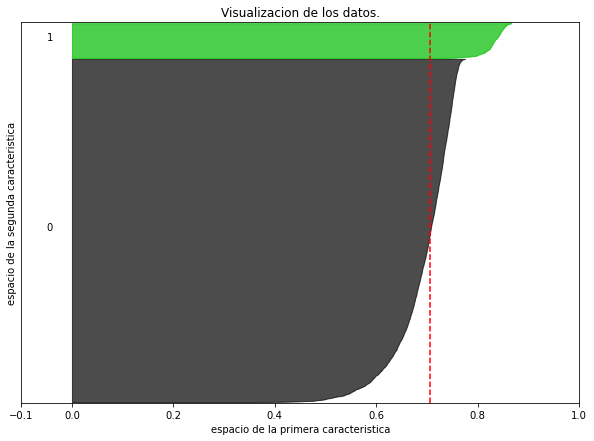

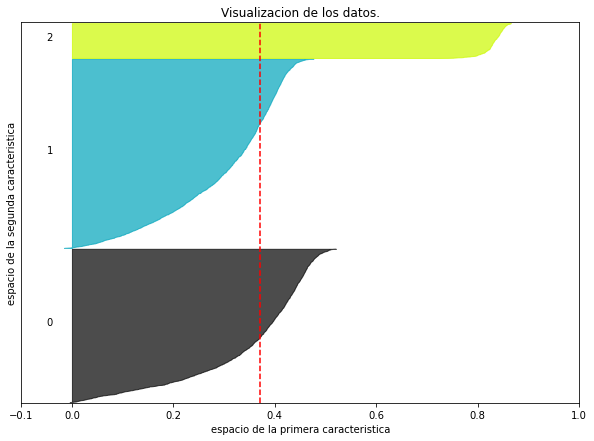

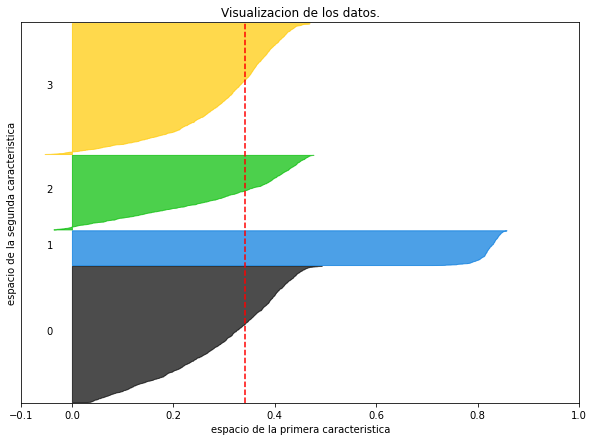

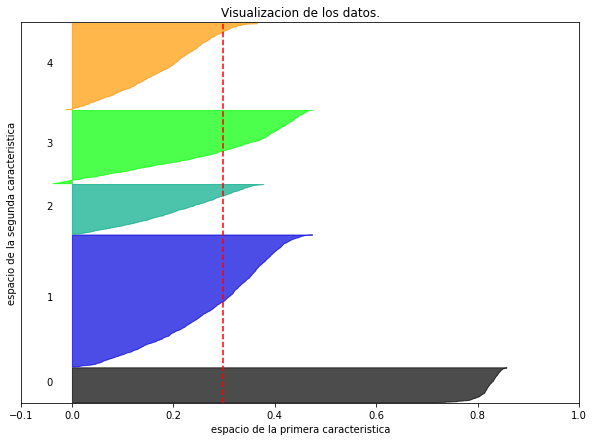

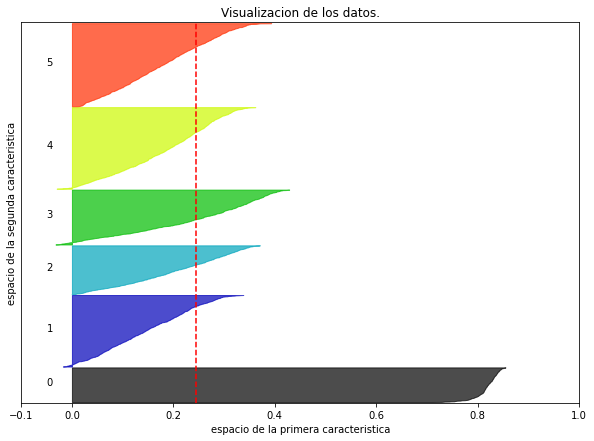

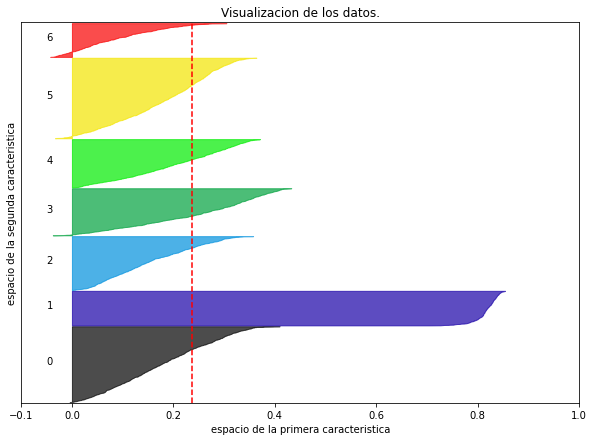

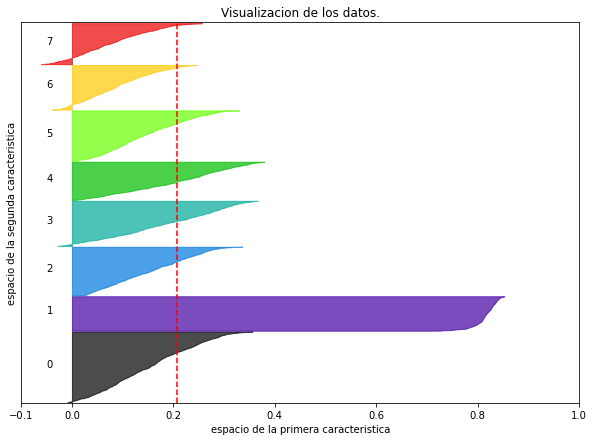

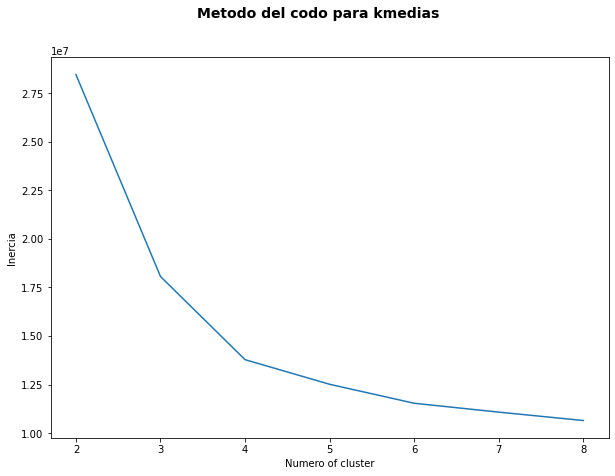

In [19]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X = df_skills

range_n_clusters = [ 2, 3, 4, 5, 6,  7, 8]
sse ={}
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    sse[n_clusters] = clusterer.inertia_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
#    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#   # ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
#   #             c=colors, edgecolor='k')
##
##    # Labeling the clusters
##    centers = clusterer.cluster_centers_
##    # Draw white circles at cluster centers
#    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                c="white", alpha=1, s=200, edgecolor='k')
#
#    for i, c in enumerate(centers):
#        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                    s=50, edgecolor='k')
#
#    ax2.set_title("Visualizacion de los datos.")
#    ax2.set_xlabel("espacio de la primera caracteristica")
#    ax2.set_ylabel("espacio de la segunda caracteristica")
#
#    plt.suptitle(("Analisis de silueta para Kmedias "
#                  "con n_clusters = %d" % n_clusters),
#                 fontsize=14, fontweight='bold')
    #plt.savefig("kmeans_%d" % n_clusters, dpi=300)

plt.show()

fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(10, 7)
plt.suptitle(("Metodo del codo para kmedias "),
                 fontsize=14, fontweight='bold')
ax1.plot(list(sse.keys()), list(sse.values()))
ax1.set_xlabel("Numero of cluster")
ax1.set_ylabel("Inercia")

clusterer = KMeans(n_clusters=4, random_state=10)
cluster_labels = clusterer.fit_predict(X)
    
colors = cm.nipy_spectral(cluster_labels.astype(float) / 4)
#ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
#ax2.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

#for i, c in enumerate(centers):
#    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

#ax2.set_title("Visualizacion de los datos.")
#ax2.set_xlabel("espacio de la primera caracteristica")
#ax2.set_ylabel("espacio de la segunda caracteristica")

#plt.savefig("kmeans_elbow", dpi=300)
plt.show()



La división en dos clústers muestra un división muy satisfactoria en terminos del coeficiente _silhouette_, ambos grupos están distanciados en el espacio de características que evaluamos. La desventaja de esta clusterización es que es muy desbalaceada. Tenemos un grupo un cluster con coeficiente _silhouette_ promedio mayor a 0.8, que es varias veces menor en términos de cantidad de elementos que el otro.

El desbalance de los clusters es un indicio de que el clúster mayor puede tener una estructura de clústers internos. Efectivamente, al considerar más clusters, siempre aparece uno de similares características al menor de los 2 iniciales, con un perfil _silhouette_ idéntico independientemente de la cantidad de culsters usados, entre 2 y 8.

A medida que incrementamos el número de clústers, los perfiles _silhouette_ se vuelven más desbalanceados internamente. Los clústers en los que se divide el mayor, están cerca por lo que al subdividirlo más y más aparecen en cada cluśter más  elementos con coeficientes _silhouette_ bajo, e incluso negativo.

Utilizando el criterio del codo seleccionamos 4 clústers para subdividir la muestra ya en el gráfico de inercia versus clústers tiene el mayor cambio de pendiente en este caso.

# 4.-Clustering-Mean-Shift 

- NO es necesario definirle la cantidad de grupos/clusters
- NO es escalable, computacionalmente es muy pesado. Cada dato tienen un proceso iterativo en donde en cada iteración considera los vecinos a menos de un radio de distancia.
- Hipeparámetros: radio (de cobertura para cálculo de media)

In [51]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

ms = MeanShift(n_jobs=3)
#ms = MeanShift(bandwidth=70, n_jobs=3) # encuentra 6

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero estimado de clusters para Mean Shift : %d" % n_clusters_)

# Etquetas de los elementos de los clusters


Numero estimado de clusters para Mean Shift : 2


In [52]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[34]
skill_2=skills_ratings[38]

MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [54]:
df_clusters['MeanShift'] = ms.labels_ #clusters2
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms.labels_)+1, 'clusters, según los hiperparámetros por defecto')

Kmeans encontró:  4 clusters, nosotros lo forzamos
Mean shift encontró  2 clusters, según los hiperparámetros por defecto


**EVALUACIÓN**

**EJERCICIO EN GRUPO: Análisis exploratorio de los clusters, usando las clases asignadas por MeanShift** 

In [55]:
#Cantidad de observaciones por Cluster
#Análisis descriptivo separando por Cluster
#Tabla de contingencia alguna categórica vs clusters
#Silohuette?


**Pregunta: normalizamos/estandarizamos la base?**

**Ahora vemos que agrupamientos podemos hacer excluyendo los arqueros**

# 5.-Clustering-con-Kmeans-sin-arqueros

In [66]:
n=10000

df_n=df.loc[:n]
df_n=df_n[(df_n["player_positions"]!='GK')&(df_n['overall']>69)]

skills_ratings=['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
                'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
                'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve',
                'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
                'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
                'movement_reactions', 'movement_balance', 'power_shot_power',
                'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
                'mentality_aggression', 'mentality_interceptions', 'mentality_positioning',
                'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking',
                'defending_standing_tackle', 'defending_sliding_tackle']

df_skills=df_n[skills_ratings]


In [67]:
for i in range(len(skills_ratings)):
    print(i, skills_ratings[i])

0 pace
1 shooting
2 passing
3 dribbling
4 defending
5 physic
6 attacking_crossing
7 attacking_finishing
8 attacking_heading_accuracy
9 attacking_short_passing
10 attacking_volleys
11 skill_dribbling
12 skill_curve
13 skill_fk_accuracy
14 skill_long_passing
15 skill_ball_control
16 movement_acceleration
17 movement_sprint_speed
18 movement_agility
19 movement_reactions
20 movement_balance
21 power_shot_power
22 power_jumping
23 power_stamina
24 power_strength
25 power_long_shots
26 mentality_aggression
27 mentality_interceptions
28 mentality_positioning
29 mentality_vision
30 mentality_penalties
31 mentality_composure
32 defending_marking
33 defending_standing_tackle
34 defending_sliding_tackle


In [68]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

# Número de clusters buscado
n_clust = 3

km = KMeans(n_clusters=n_clust)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_


In [69]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[28]
skill_2=skills_ratings[32]


kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

# 6.-Clustering-Mean-Shift-sin-arqueros 

In [70]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition


#ms = MeanShift(bandwidth=2, bin_seeding=True)
#ms = MeanShift(bandwidth=58, n_jobs=3) #  Encuentra 6
ms = MeanShift(n_jobs=3)

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero de clusters encontrado por Mean Shift : %d" % n_clusters_)


Numero de clusters encontrado por Mean Shift : 1


In [61]:
data=[]
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86


#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[28]
skill_2=skills_ratings[32]


MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [62]:
df_clusters=df_skills
df_clusters['kmeans'] = km.labels_ #clusters
df_clusters['MeanShift'] = ms.labels_ #clusters2

In [95]:
df_clusters

,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,kmeans,MeanShift
0,87.0,92.0,92.0,96.0,39.0,66.0,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,3,1
1,90.0,93.0,82.0,89.0,35.0,78.0,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,3,1
2,91.0,85.0,87.0,95.0,32.0,58.0,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,3,1
4,91.0,83.0,86.0,94.0,35.0,66.0,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,3,1
5,76.0,86.0,92.0,86.0,61.0,78.0,93,82,55,92,82,86,85,83,91,91,77,76,78,91,76,91,63,89,74,90,76,61,88,94,79,91,68,58,51,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5652,55.0,58.0,60.0,65.0,66.0,79.0,45,51,61,67,50,65,49,47,64,69,56,55,53,68,52,69,65,90,74,65,82,70,66,65,53,69,65,67,66,1,0
5654,83.0,60.0,66.0,70.0,36.0,57.0,68,60,46,69,49,69,55,60,66,70,84,83,82,62,67,66,56,69,61,55,34,21,63,65,59,62,50,29,34,3,1
5655,80.0,64.0,64.0,75.0,25.0,63.0,63,64,51,64,58,72,71,44,65,77,84,77,89,62,86,70,58,76,60,61,56,22,62,65,55,69,22,23,17,3,1
5656,73.0,58.0,68.0,74.0,57.0,79.0,62,53,48,71,48,72,68,62,70,74,74,72,80,67,82,73,69,82,81,59,75,55,57,69,57,67,55,64,55,1,0


**Análisis exploratorio de las clases**